<a href="https://colab.research.google.com/github/jaehee72/2020-2021study-/blob/main/VAE_MNIST_tf20_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 준비 단계 

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

print(f"Tensorflow version: {tf.__version__}")

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

     |████████████████████████████████| 1.1MB 13.5MB/s 
Tensorflow version: 2.3.0


In [ ]:
!nvidia-smi

Fri Nov 13 11:29:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import keras
print(keras.__version__)

2.4.3


## 1. Callback 및 LearningRateScheduler 정의
- print_every_n_batches횟수의 배치 학습이 완료될 때 마다 현재까지 학습된 vae로 부터 새로운 이미지를 생성함   

In [ ]:
from keras.callbacks import Callback, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os

#### CALLBACKS
class CustomCallback(Callback):
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1, self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(
                self.run_folder, 
                'images', 
                'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg'
            )
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1

- learning_rate에 대한 decay 함수를 정의하여 LearningRateScheduler 객체 생성

In [ ]:
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        
        return new_lr

    return LearningRateScheduler(schedule)


## 2. VAE 모델 생성

In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping 
from keras.utils import plot_model

import numpy as np
import json
import os
import pickle

In [ ]:
class VariationalAutoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout= False
        ):

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides

        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides

        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):
        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            x = LeakyReLU()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(log_var), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon

        encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model(encoder_input, encoder_output)
        
        ### THE DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

            

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)


    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        ### COMPILATION
        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
            return r_loss_factor * r_loss

        def vae_kl_loss(y_true, y_pred):
            kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss

        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])

    def save(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
                ], f)

        self.plot_model(folder)

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):
        custom_callback = CustomCallback(
            run_folder=run_folder, 
            print_every_n_batches=print_every_n_batches,
            initial_epoch=initial_epoch,
            vae=self
        )

        lr_sched = step_decay_schedule(
            initial_lr=self.learning_rate,
            decay_factor=lr_decay,
            step_size=1
        )

        checkpoint1 = ModelCheckpoint(
            os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5"),
            save_weights_only = True,
            verbose=1
        )
        checkpoint2 = ModelCheckpoint(
            os.path.join(run_folder, 'weights/weights.h5'),
            save_weights_only = True,
            verbose=1
        )

        early_stopping = EarlyStopping(monitor='loss', patience=5)

        callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched, early_stopping]

        self.model.fit(     
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
        )
    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)

## 3. FASHION_MNIST 데이터 로드

In [ ]:
from keras.datasets import fashion_mnist

In [ ]:
def load_mnist():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape(x_test.shape + (1,))

    return (x_train, y_train), (x_test, y_test)

In [ ]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


## 4. 모델 생성 및 준비

- 생성 파일 저장 폴더 준비

In [ ]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists("run"):
    os.mkdir("run")

if not os.path.exists("run/{}".format(SECTION)):
    os.mkdir("run/{}".format(SECTION))

if not os.path.exists("run/{0}/{1}".format(SECTION, '_'.join([RUN_ID, DATA_NAME]))):
    os.mkdir("run/{0}/{1}".format(SECTION, '_'.join([RUN_ID, DATA_NAME])))   

if not os.path.exists(os.path.join(RUN_FOLDER, 'viz')):
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))

if not os.path.exists(os.path.join(RUN_FOLDER, 'images')):
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))

if not os.path.exists(os.path.join(RUN_FOLDER, 'weights')):
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

- 모델 생성 

In [ ]:
vae = VariationalAutoencoder(
    input_dim = (28, 28, 1)
    , encoder_conv_filters = [32, 64, 64, 64]
    , encoder_conv_kernel_size = [3, 3, 3, 3]
    , encoder_conv_strides = [1, 2, 2, 1]
    , decoder_conv_t_filters = [64, 64, 32, 1]
    , decoder_conv_t_kernel_size = [3, 3, 3, 3]
    , decoder_conv_t_strides = [1, 2, 2, 1]
    , z_dim = 2
)


vae.save(RUN_FOLDER)

In [ ]:
vae.encoder.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu_7[0][0]              
______________________________________________________________________________________

In [ ]:
vae.decoder.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 14, 14, 64)      

## 5. 훈련

In [ ]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

vae.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Epoch 1/200


_SymbolicException: ignored

## 6. 완성된 모델의 재로드

In [ ]:
def load_model(model_class, folder):
    with open(os.path.join(folder, 'params.pkl'), 'rb') as f:
        params = pickle.load(f)

    model = model_class(*params)

    model.load_weights(os.path.join(folder, 'weights/weights.h5'))

    return model

In [ ]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

## 7. 원래 이미지 재구성하기

In [ ]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = vae.encoder.predict(example_images)
np.round(z_points, 1)

array([[ 0. ,  1. ],
       [-1.5, -1. ],
       [-0.7, -1.4],
       [ 0.2,  0.9],
       [-0.5,  0.3],
       [-1.2,  0.2],
       [-1.1,  1.3],
       [-0.2,  0.3],
       [ 2.3,  1.2],
       [-1.5, -0.6]], dtype=float32)

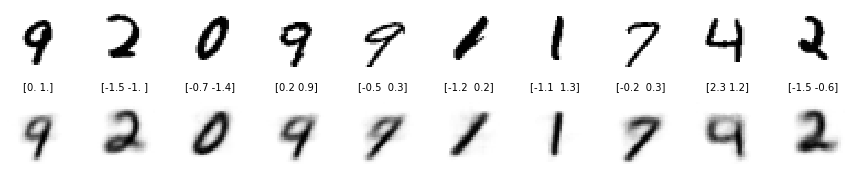

In [ ]:
reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i], 1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

## 8. 테스트 이미지 5000개에 대한 인코딩 결과 확인하기 

example_labels: [8 6 7 ... 2 5 5]
-3.6454365 4.1464005
-4.172832 3.9054735


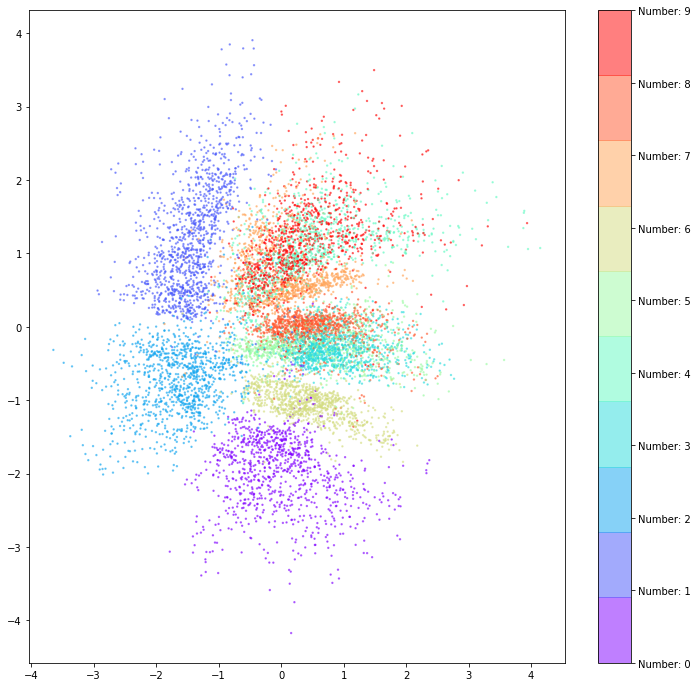

In [ ]:
n_to_show = 10000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

print("example_labels: {0}".format(example_labels))

z_points = vae.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

print(min_x, max_x)
print(min_y, max_y)

plt.figure(figsize=(figsize, figsize))
scattered_points = plt.scatter(z_points[:, 0] , z_points[:, 1], c=example_labels, alpha=0.5, s=2, cmap=plt.cm.get_cmap('rainbow', 10))
plt.colorbar(mappable=scattered_points, format='Number: %d')
plt.show()

## 9. 새로운 이미지 생성하기

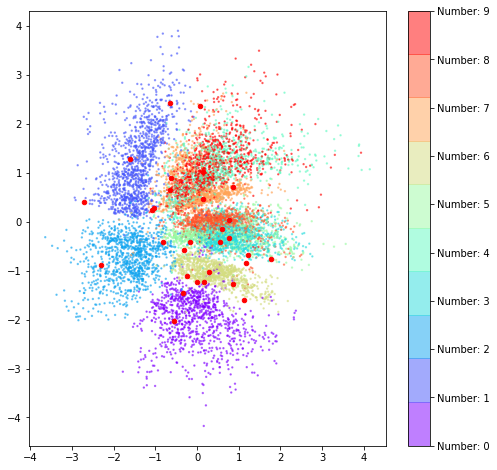

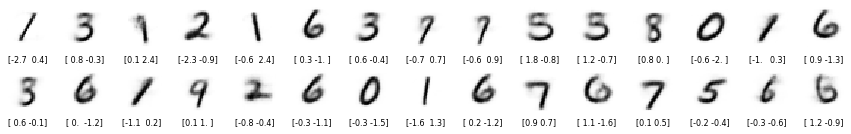

In [ ]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
scattered_points = plt.scatter(z_points[:, 0] , z_points[:, 1], c=example_labels, alpha=0.5, s=2, cmap=plt.cm.get_cmap('rainbow', 10))
plt.colorbar(mappable=scattered_points, format='Number: %d')

grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size * grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

[-2.32634787 -1.54165318 -1.20990385 -0.97517455 -0.78469643 -0.61919262
 -0.46917106 -0.32906671 -0.19516579 -0.06468971  0.06468971  0.19516579
  0.32906671  0.46917106  0.61919262  0.78469643  0.97517455  1.20990385
  1.54165318  2.32634787]
[-2.32634787 -1.54165318 -1.20990385 -0.97517455 -0.78469643 -0.61919262
 -0.46917106 -0.32906671 -0.19516579 -0.06468971  0.06468971  0.19516579
  0.32906671  0.46917106  0.61919262  0.78469643  0.97517455  1.20990385
  1.54165318  2.32634787]


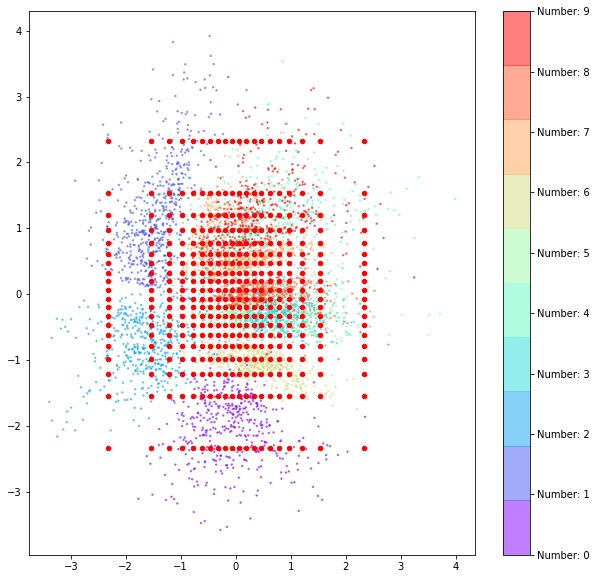

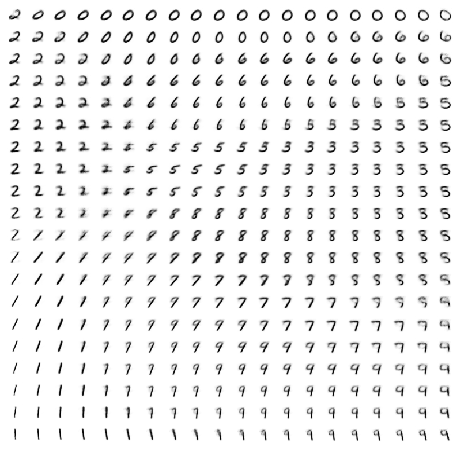

In [ ]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

plt.figure(figsize=(10, 10))
scattered_points = plt.scatter(z_points[:, 0], z_points[:, 1], c=example_labels, alpha=0.5, s=2, cmap=plt.cm.get_cmap('rainbow', 10))
plt.colorbar(mappable=scattered_points, format='Number: %d')

x = norm.ppf(np.linspace(0.01, 0.99, grid_size)) # percent point function
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
print(x)
print(y)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c='red', alpha=1, s=20)
plt.show()

reconst = vae.decoder.predict(z_grid)

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

## 10. 잠재 공간의 각 포인트를 p-값으로 변환하기
- (-$\infty$, $\infty$)의 값을 (0, 1) 사이 값으로 매핑하기   

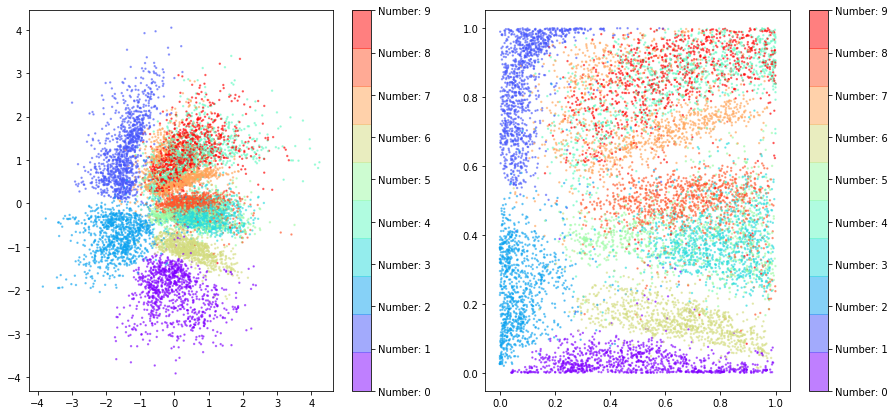

In [ ]:
from scipy.stats import norm

n_to_show = 10000

fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)
p_points = norm.cdf(z_points) #cdf: cumulative distribution function

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
scattered_points = plt.scatter(z_points[:, 0] , z_points[:, 1], c=example_labels, alpha=0.5, s=2, cmap=plt.cm.get_cmap('rainbow', 10))
plt.colorbar(mappable=scattered_points, format='Number: %d')

ax = fig.add_subplot(1, 2, 2)
scattered_points = plt.scatter(p_points[:, 0] , p_points[:, 1], c=example_labels, alpha=0.5, s=2, cmap=plt.cm.get_cmap('rainbow', 10))
plt.colorbar(mappable=scattered_points, format='Number: %d')

plt.show()

In [ ]:
!ls -al run/vae/0002_digits/images

total 15340
drwxr-xr-x 2 root root 135168 Jan  2 00:11 .
drwxr-xr-x 5 root root   4096 Jan  1 22:40 ..
-rw-r--r-- 1 root root    981 Jan  1 23:23 img_001_0.jpg
-rw-r--r-- 1 root root    784 Jan  1 23:24 img_001_1000.jpg
-rw-r--r-- 1 root root    844 Jan  1 23:23 img_001_100.jpg
-rw-r--r-- 1 root root    782 Jan  1 23:24 img_001_1100.jpg
-rw-r--r-- 1 root root    810 Jan  1 23:24 img_001_1200.jpg
-rw-r--r-- 1 root root    809 Jan  1 23:24 img_001_1300.jpg
-rw-r--r-- 1 root root    787 Jan  1 23:24 img_001_1400.jpg
-rw-r--r-- 1 root root    789 Jan  1 23:24 img_001_1500.jpg
-rw-r--r-- 1 root root    826 Jan  1 23:24 img_001_1600.jpg
-rw-r--r-- 1 root root    812 Jan  1 23:24 img_001_1700.jpg
-rw-r--r-- 1 root root    803 Jan  1 23:24 img_001_1800.jpg
-rw-r--r-- 1 root root    826 Jan  1 23:23 img_001_200.jpg
-rw-r--r-- 1 root root    855 Jan  1 23:23 img_001_300.jpg
-rw-r--r-- 1 root root    789 Jan  1 23:23 img_001_400.jpg
-rw-r--r-- 1 root root    774 Jan  1 23:23 img_001_500.jpg
-rw-r

In [ ]:
from IPython.display import Image, display
for idx in range(1, 200+1):
    display(Image('./run/vae/0002_digits/images/img_{0}_0.jpg'.format(str(idx).zfill(3))))

In [ ]:
!ls -al run/vae/0002_digits/viz

total 300
drwxr-xr-x 2 root root   4096 Jan  1 22:40 .
drwxr-xr-x 5 root root   4096 Jan  1 22:40 ..
-rw-r--r-- 1 root root  79348 Jan  1 23:23 decoder.png
-rw-r--r-- 1 root root 111138 Jan  1 23:23 encoder.png
-rw-r--r-- 1 root root  98757 Jan  1 23:23 model.png


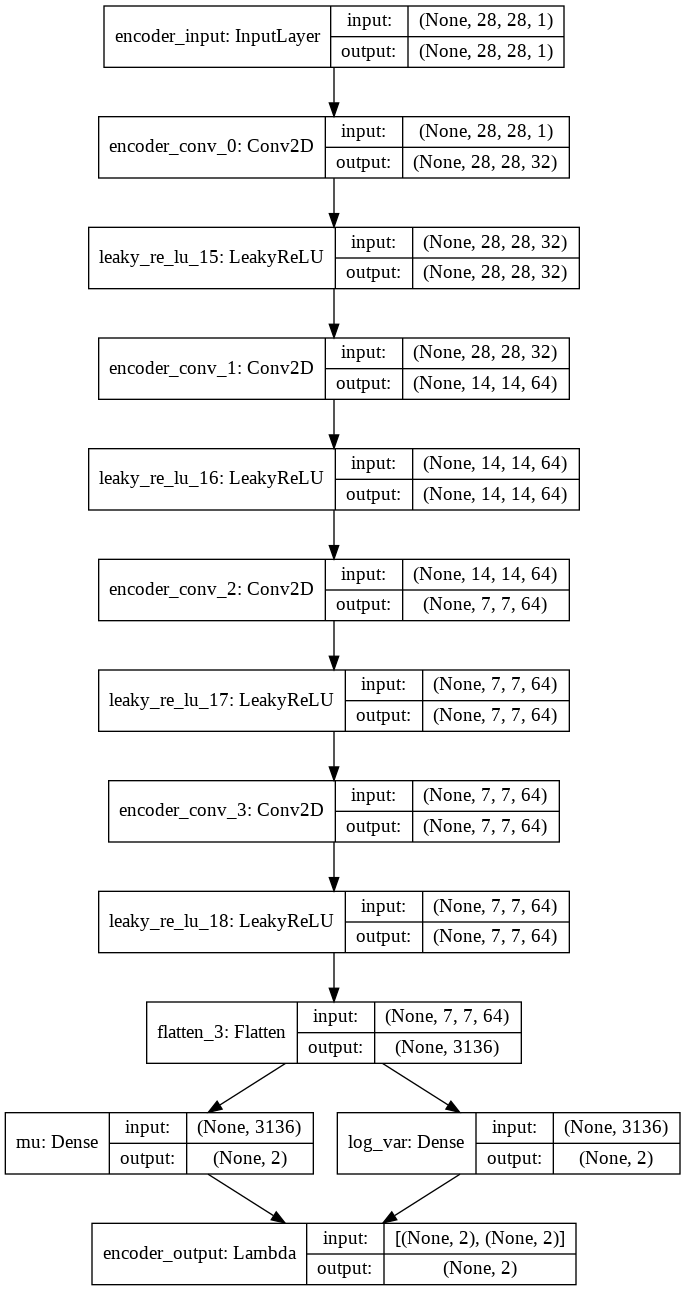

In [ ]:
display(Image('./run/vae/0002_digits/viz/encoder.png'))

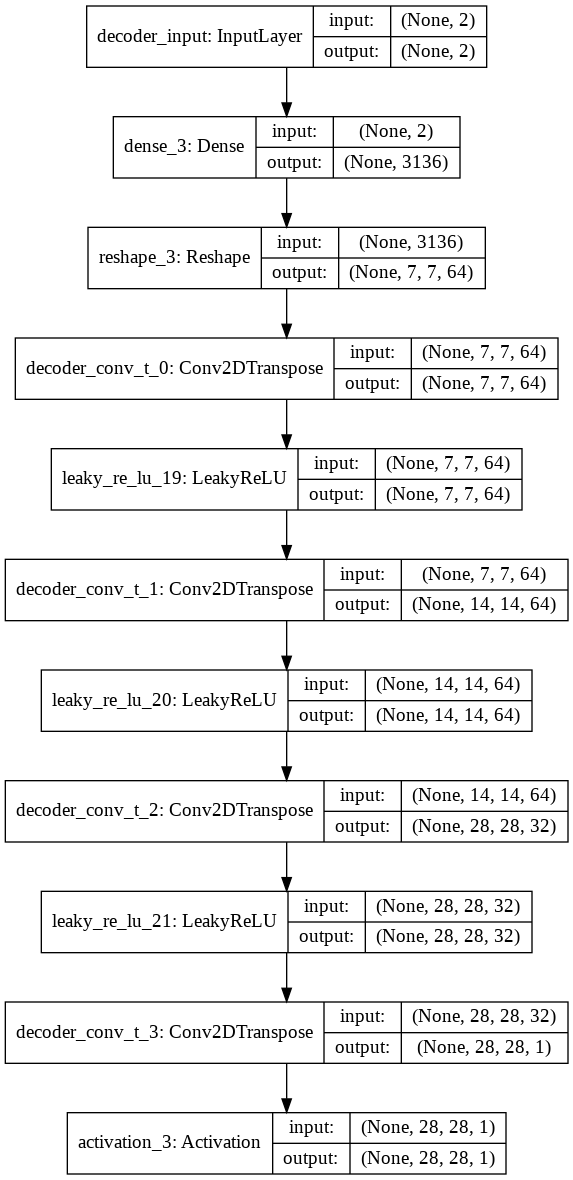

In [ ]:
display(Image('./run/vae/0002_digits/viz/decoder.png'))

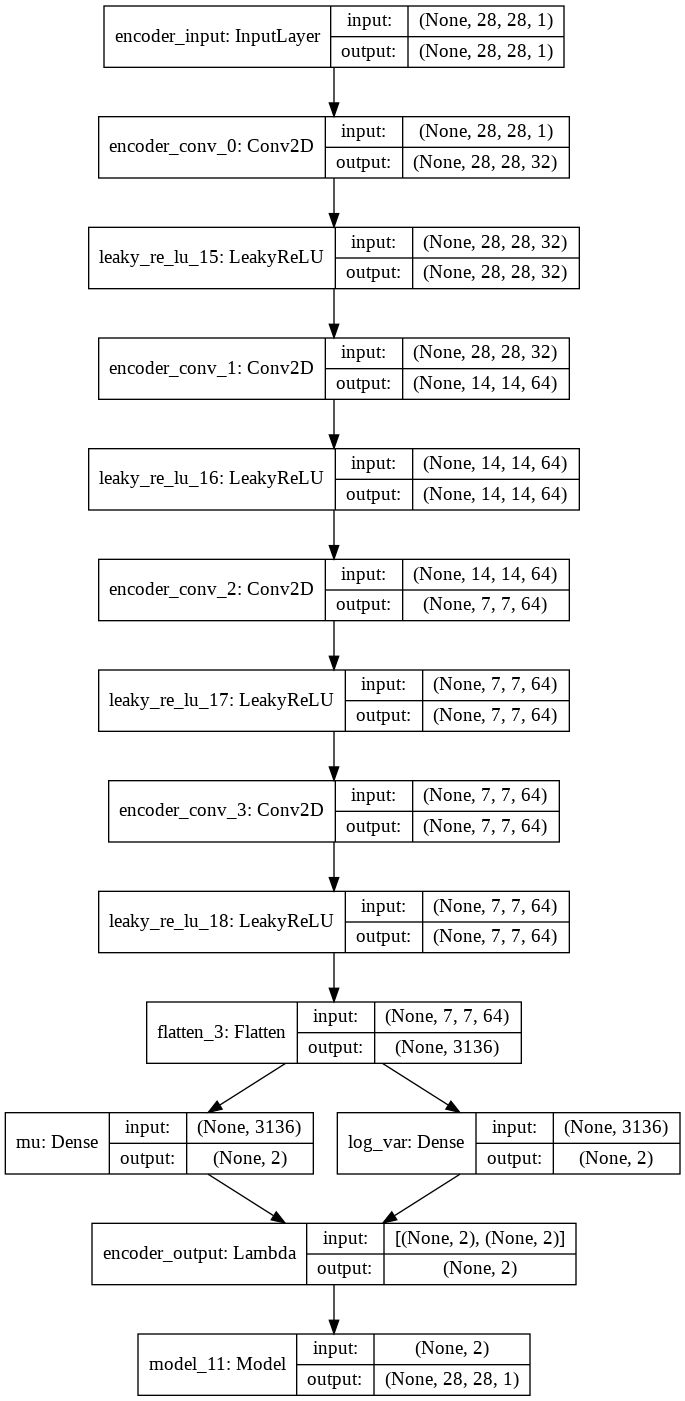

In [ ]:
display(Image('./run/vae/0002_digits/viz/model.png'))